# Summarize model performances

This notebooks plots the performances (using averaged ROC AUC scores) for models
trained with different training sets.

### Determine run parameters

In [1]:
# ----------------- Parameters for interactive development --------------
P = {
    "workflow.run_environment": "dev",
}

In [2]:
# - During automated runs parameters will be injected in the below cell -

In [3]:
# Parameters
P = {"_parameters_actor_name": "parameter_for_task_0xb55aa626eaaaa2f1"}


In [4]:
# -----------------------------------------------------------------------

---

### Notebook code

In [5]:
#
import pandas as pd
import matplotlib.pyplot as plt

#
from composable_logs.tasks.task_opentelemetry_logging import get_task_context

In [6]:
logger = get_task_context(P)

2023-07-21 06:36:26,132	INFO worker.py:1364 -- Connecting to existing Ray cluster at address: 172.17.0.2:34450...


2023-07-21 06:36:26,141	INFO worker.py:1544 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 


/home/host_user/.local/lib/python3.8/site-packages/ray/runtime_context.py:27: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
Use get_job_id() instead
  "job_id": self.job_id,
/home/host_user/.local/lib/python3.8/site-packages/ray/runtime_context.py:28: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
Use get_node_id() instead
  "node_id": self.node_id,


In [7]:
from composable_logs.tasks.task_opentelemetry_logging import get_logged_values
from composable_logs.opentelemetry_helpers import _get_all_spans, Spans

In [8]:
def get_model_benchmarks():
    """
    Query the OpenTelemetry logs for *this pipeline run* and return
    all key-values logged from all runs of the benchmark-model.py task

    For testing a json file with OpenTelemetry spans (as an array)
    can be used as follows:

    - Create output directory `mkdir /tmp/spans`
    - Run unit tests. This will create pipeline-outputs/opentelemetry-spans.json
    - Convert this json-array into jsonl format as follows

    jq -c '.[]' /pipeline-outputs/opentelemetry-spans.json > /tmp/spans/data.txt

    """
    spans: Spans = Spans(_get_all_spans())
    print(f" - Found {len(spans)} spans")

    benchmark_spans = (
        spans
        # -
        .filter(["name"], "execute-task")
        # -
        .filter(["attributes", "task.id"], "benchmark-model")
    )

    result = []
    for s in benchmark_spans:
        result.append(
            {
                "span_id": s["context"]["span_id"],
                "nr_train_images": s["attributes"]["task.nr_train_images"],
                "data": get_logged_values(spans.bound_under(s)),
            }
        )

    return result


def adjust_pandas(df):
    def column_renamer(col_name: str) -> str:
        return (
            col_name
            # -- 'data.roc_auc_per_digit.4' -> 'roc_auc.4'
            .replace("data.roc_auc_per_digit", "roc_auc")
            # -- 'data.roc_auc_class_mean' -> 'roc_auc_mean'
            .replace("data.roc_auc_class_mean", "roc_auc_mean")
        )

    return df.rename(column_renamer, axis="columns").sort_values(by="nr_train_images")

In [9]:

df_data = adjust_pandas(pd.json_normalize(get_model_benchmarks()))

 - Found 250 spans


In [10]:
df_data.round(4)

,span_id,nr_train_images,roc_auc_mean,roc_auc.0,roc_auc.1,roc_auc.2,roc_auc.3,roc_auc.4,roc_auc.5,roc_auc.6,roc_auc.7,roc_auc.8,roc_auc.9
3,0x6cd4b893e1dbf9cf,600,0.9990,1.0,0.9992,1.0,0.9997,0.9990,0.9989,1.0000,0.9998,0.9948,0.9988
2,0xcc9f8c5c07c932cc,800,0.9989,1.0,0.9988,1.0,0.9998,0.9995,0.9992,1.0000,0.9999,0.9927,0.9995
0,0x365f4bfce5213a68,1000,0.9992,1.0,0.9990,1.0,0.9999,0.9996,0.9994,0.9999,0.9998,0.9950,0.9996
1,0x72b590358e333f11,1200,0.9994,1.0,0.9991,1.0,0.9999,0.9997,0.9997,0.9999,0.9998,0.9958,0.9997


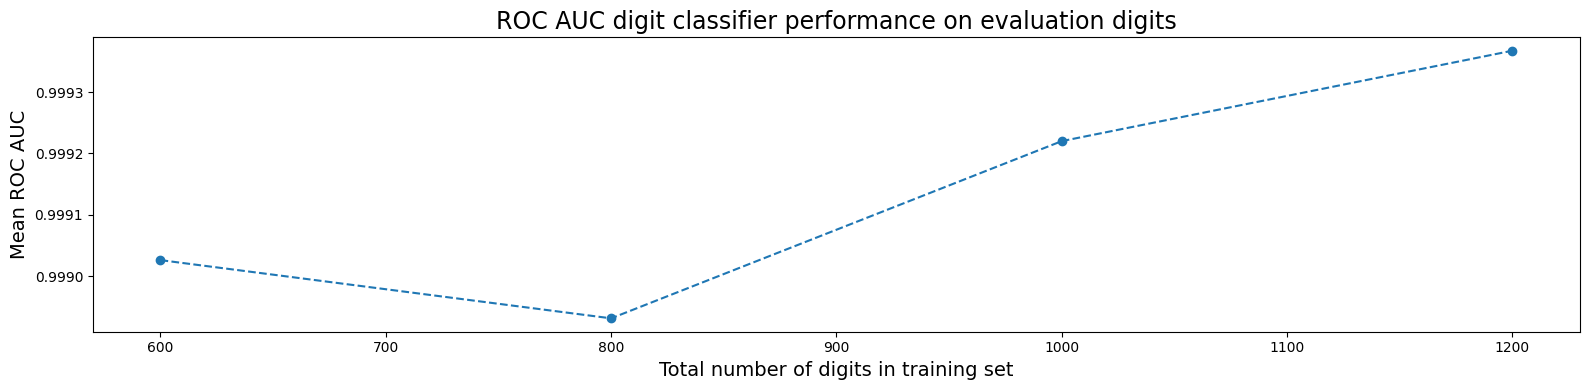

In [11]:
def plot_classifier_performance_summary(df_data):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4), sharex=True)

    #
    ax.plot(
        df_data["nr_train_images"], df_data["roc_auc_mean"], marker="o", linestyle="--"
    )
    ax.set_title(
        f"ROC AUC digit classifier performance on evaluation digits", fontsize=17
    )
    ax.set_xlabel("Total number of digits in training set", fontsize=14)
    ax.set_ylabel("Mean ROC AUC", fontsize=14)

    fig.tight_layout()
    fig.show()

    return fig


fig = plot_classifier_performance_summary(df_data)

In [12]:
logger.log_figure("auc-roc-model-performances.png", fig)

In [13]:
###